Things you should probably add: print out the percent of edges correct(ie len(intersection) / len(ground_truth_edge_set)) and percent of 0's (total_possible_edges - len(union) / total_possible_edges - len(ground_truth_edges) I reccomend modifying the existing algorithm to return a list of these rather than the single float it currently is returning and then modifying the print statement to be clear about which value is which.

get_file_paths may need modification to allow for certain changes in the correlation arguments as they will change the file name

Run_Scripts has multiple examples of each individual file that can be run, if you want to run more than 100 through you will need to modify those files, I reccomend making them for loops that use the iterative number value in the call to the files. The other Jupyter Notebook contains the code for replacing invalid sets with valid ones.

For making Run_Scripts iterate on a csv, write a parser that receives a csv with the corresponding 3 file location arguments in the respective first 3 columns, and using the columns after that for the additional arguments specific to the algorithm. You may want to add additional functionality to Correlation in particular later, in which case I reccomend maintaining the same order of parameters in the CSV as in the actual program call within the shell script for peak clarity.

In [2]:
import pandas as pd
import numpy as np
import os
from os import path
import math
from venn import venn


In [153]:
total_frames = 100

def correct_float_to_int(number, threshold_of_ceiling):
    correct_int = int(number)
    if number - int(number) > threshold_of_ceiling:
        correct_int += 1
    return correct_int

def get_file_paths(basePaths, n):
    """
    Given the base paths returns the filepaths for each function type to be used in getting dataframes from the files
    """
    filepaths = {}
    for path in basePaths:
        filepaths[path[0]] = []
        for index in range(1, n+1):
            if (path[1] == 'Xiao'):
                filepaths[path[0]].append(path[0] + "/Chiquet_" + str(index) + "/Sign of Jaccobian for Iteration_0.csv")
            elif(path[1] == 'Correlation'):
                filepaths[path[0]].append(path[0] + "/Chiquet_" + str(index) + "/graph_centrality_pearson_0.5_degree/Metric Network.csv")
            else:
                filepaths[path[0]].append(path[0] + "/Chiquet_" + str(index) + "/Adjacency_Matrix_Chiquet_" + str(index) + ".csv")
    return filepaths

def discretize_to_0_or_1(row):
    """
    Used for ensuring edges are standardized in representation across different algorithms
    """
        for index in range(len(row)):
            if row[index] != 0:
                row[index] = 1
        return row

def create_pandaframes(file_paths, source_file, total_taxa):
    """
    Creates Pandas dataframes for all of the files provided as an argument.
    """
    def fix_correlation(dataframe):
        """
        Due to the unique nature of correlations output sets, there is a possibility that empty rows and columns can occur. As such to avoid errors a full dataframe needs
        to be generated.
        """
        def convert_row_index(index, names):
            """
            Gets the correct row index for the dataframe, from the potentially differently sized correlation file dataframe.
            """
            return int(names[index].split("V",1)[1])-1
        new_dataframe = pd.DataFrame(np.zeros((total_taxa, total_taxa)))
        column_names = []
        for x in range(1, total_taxa + 1):
            column_names.append("V" + str(x))
        new_dataframe.columns = column_names
        row_names = dataframe['Unnamed: 0']
        for column in dataframe.columns[1:]:
            for row in range(0, len(row_names)):
                new_dataframe[column][convert_row_index(row, row_names)] = dataframe[column][row]
        return new_dataframe

    def correct_dataframes(frame_group):
        """
        Fixes Dataframes that have useless additional data that will not be used. Mostly just for Ma
        """
        for frame in frames[frame_group]:
            removals = list(range(total_taxa, len(frame.columns)))
            frame.drop(frame.columns[removals], axis = 1, inplace=True)
            column_names = []
            for x in range(1, total_taxa + 1):
                column_names.append("V" + str(x))
            frame.columns = column_names

    frames = {}
    for group in source_files:
        group_name = group[0].split('/')[-1]
        frames[group_name] = []
        for index in range(0, len(file_paths[group[0]])):
            df = pd.read_csv(file_paths[group[0]][index])
            if(group[1] == 'Xiao'):
                df = df.iloc[: , 1:]
            elif(group[1] == 'Correlation'):
                df = fix_correlation(df)
            frames[group_name].append(np.ceil(df).astype(int).apply(discretize_to_0_or_1))
        if frames[group_name][0].columns[0] != "V1":
            correct_dataframes(group_name)
    return frames

def create_edge_set(frame, total_samples):
    """
    Given a dataframe, it converts all nonzero dataframe values into a python set of strings corresponding to edges
    """
        new_set = set()
        for column in frame.columns:
            for index in range(total_samples):
                if(frame[column][index] != 0):
                    new_set.add(str(column) + ',' + str(index))
        return new_set

def create_venn_sets(frames, total_taxa, total_samples, threshold_of_ceiling):
    """
    Creates all of the sets to be used in displaying the venn of the algorithms.
    """
    def average_frame_group(frame_group_key):
        frame_group = frames[frame_group_key]
        average_frame = pd.DataFrame(np.zeros((total_samples, total_taxa)), columns=frame_group[0].columns)
        for column in frame_group[0].columns:
            for index in range(total_samples):
                average = 0
                for frame_index in range(0, total_frames):
                    average += frame_group[frame_index][column][index]
                average_frame[column][index] = correct_float_to_int(average / total_frames, threshold_of_ceiling)
        return average_frame

    venn_sets = {}
    for frame_group in frames.keys():
        average = average_frame_group(frame_group)
        venn_sets[frame_group] = create_edge_set(average, total_samples)
    return venn_sets 
    
def display_venn_of_n_groups(groups):
    venn(groups)

def print_percent_correct_of_all_algorithms(frames, total_samples, ground_truth_sets):
    """
    Prints the percentage of correctness of all combination of algorithms by comparing them to the ground truth.
    """
    def get_all_intersections(frames):
        """
        Collects every set for each algorithm and every possible intersection set of algorithms.
        """
        def get_sets_from_dataframes(frames):
            """
            Returns the sets of edges for each dataframe
            """
            list_of_frames = []
            for key in frames.keys():
                frame_sets = frames[key]
                for index in range(total_frames):
                    frame_sets[index] = create_edge_set(frame_sets[index], total_samples)
                list_of_frames.append((key, frame_sets))
            return list_of_frames

        def get_all_intersections_recursion(title, curr_set_group, remaining_set_groups):
            """
            Uses recursion to get every intersection of algorithms in an efficient manner, and return the sets.
            """
            results = [(title, curr_set_group)]
            if (len(remaining_set_groups) > 0):
                for set_index in range(len(remaining_set_groups)):
                    remaining_set_groups_copy = remaining_set_groups.copy()[set_index:]
                    add_set = remaining_set_groups_copy.pop(0)[1].copy()
                    curr_set_group_copy = curr_set_group.copy()
                    for index in range(total_frames):
                        curr_set_group_copy[index] = curr_set_group_copy[index].intersection(add_set[index])
                    results.extend(get_all_intersections_recursion(title + " & " + remaining_set_groups[set_index][0], curr_set_group_copy, remaining_set_groups_copy))
            return results

        frame_sets = get_sets_from_dataframes(frames)
        results = []
        while (len(frame_sets) > 0):
            first_set = frame_sets.pop()
            results.extend(get_all_intersections_recursion(first_set[0], first_set[1], frame_sets))
        return results

    def get_percent_correct_of_set(calculated_set, ground_truth, total_possible_edges):
        """
        The total incorrect edges is equal to the symmetric difference between the ground truth set of edges and the calculated set of edges. As such
        the percentage of correct edges and nonedges is equal to the total possible edges minus the incorrect edges divided by the total possible edges.
        """
        return float(total_possible_edges - len(calculated_set.copy().symmetric_difference(ground_truth.copy()))) / float(total_possible_edges)

    def get_percent_correct_of_set_group(set_group):
        """
        Given a grouping of sets, get the percentage of correct entries accross all files in the group relative to the .
        """
        total_percentage = 0
        for index in range(len(ground_truth_sets)):
            total_percentage += get_percent_correct_of_set(set_group[1][index], ground_truth_sets[index], total_samples*total_samples)
        return total_percentage / total_frames

    set_groups = get_all_intersections(frames)
    for set_group in set_groups:
        print(set_group[0] + ": " + str(get_percent_correct_of_set_group(set_group)) + "\n")

def get_ground_truth_sets(base_file_path, total_samples):
    """
    Gets all sets of edges in the ground truth files
    """
    ground_truth_sets = []
    for x in range(total_frames):
        df = pd.read_csv(base_file_path + "Ground_Truth_" + str(x+1) + ".csv")
        ground_truth_sets.append(create_edge_set(np.ceil(df).astype(int).apply(discretize_to_0_or_1), total_samples))
    return ground_truth_sets

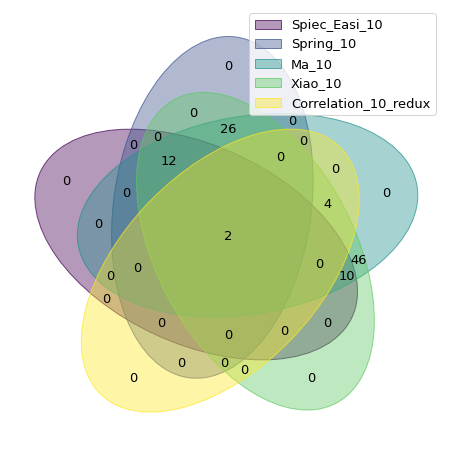

In [134]:
source_files = [("/u1/cec383/Fusion_Approach_Pipelines/Output/Spiec_Easi_10", 'Spiec_Easi'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Spring_10", 'Spring'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Ma_10", 'Ma'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Xiao_10", 'Xiao'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Correlation_10_redux", 'Correlation')]
paths = get_file_paths(source_files, total_frames)
frames = create_pandaframes(paths, source_files, 10)
venn_sets = create_venn_sets(frames, 10, 10, .01)
display_venn_of_n_groups(venn_sets)

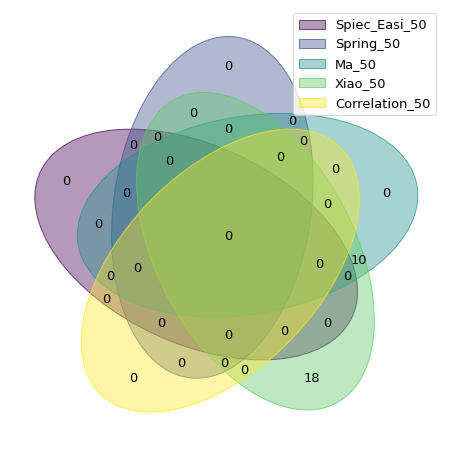

In [35]:
source_files = [("/u1/cec383/Fusion_Approach_Pipelines/Output/Spiec_Easi_50", 'Spiec_Easi'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Spring_50", 'Spring'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Ma_50", 'Ma'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Xiao_50", 'Xiao'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Correlation_50", 'Correlation')]
paths = get_file_paths(source_files, total_frames)
frames = create_pandaframes(paths, source_files, 10)
venn_sets = create_venn_sets(frames, 10, 10, 1)
display_venn_of_n_groups(venn_sets)

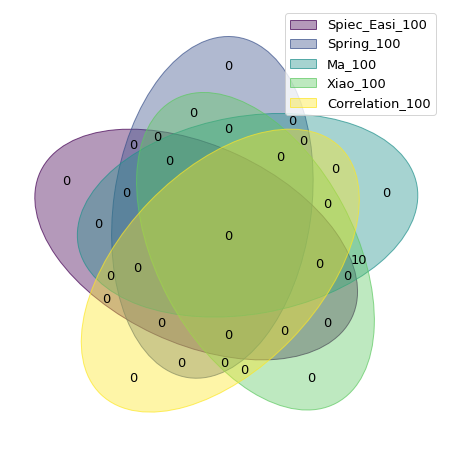

In [47]:
source_files = [("/u1/cec383/Fusion_Approach_Pipelines/Output/Spiec_Easi_100", 'Spiec_Easi'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Spring_100", 'Spring'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Ma_100", 'Ma'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Xiao_100", 'Xiao'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Correlation_100", 'Correlation')]
paths = get_file_paths(source_files, total_frames)
frames = create_pandaframes(paths, source_files, 10)
venn_sets = create_venn_sets(frames, 10, 10, 1)
display_venn_of_n_groups(venn_sets)

In [154]:
source_files = [("/u1/cec383/Fusion_Approach_Pipelines/Output/Spiec_Easi_10", 'Spiec_Easi'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Spring_10", 'Spring'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Ma_10", 'Ma'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Xiao_10", 'Xiao'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Correlation_10_redux", 'Correlation')]
paths = get_file_paths(source_files, total_frames)
frames = create_pandaframes(paths, source_files, 10)
print_percent_correct_of_all_algorithms(frames, 10, get_ground_truth_sets("/u1/cec383/Fusion_Approach_Pipelines/Datasets/Chiquet_10/", 10))

Correlation_10_redux: 0.5039000000000001

Correlation_10_redux & Spiec_Easi_10: 0.5031000000000001

Correlation_10_redux & Spiec_Easi_10 & Spring_10: 0.5029

Correlation_10_redux & Spiec_Easi_10 & Spring_10 & Ma_10: 0.5027000000000001

Correlation_10_redux & Spiec_Easi_10 & Spring_10 & Ma_10 & Xiao_10: 0.5027000000000001

Correlation_10_redux & Spiec_Easi_10 & Spring_10 & Xiao_10: 0.5029

Correlation_10_redux & Spiec_Easi_10 & Ma_10: 0.5027000000000001

Correlation_10_redux & Spiec_Easi_10 & Ma_10 & Xiao_10: 0.5027000000000001

Correlation_10_redux & Spiec_Easi_10 & Xiao_10: 0.5031000000000001

Correlation_10_redux & Spring_10: 0.5027000000000001

Correlation_10_redux & Spring_10 & Ma_10: 0.5027000000000001

Correlation_10_redux & Spring_10 & Ma_10 & Xiao_10: 0.5027000000000001

Correlation_10_redux & Spring_10 & Xiao_10: 0.5027000000000001

Correlation_10_redux & Ma_10: 0.5027000000000001

Correlation_10_redux & Ma_10 & Xiao_10: 0.5027000000000001

Correlation_10_redux & Xiao_10: 0.50

In [146]:
source_files = [("/u1/cec383/Fusion_Approach_Pipelines/Output/Spiec_Easi_50", 'Spiec_Easi'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Spring_50", 'Spring'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Ma_50", 'Ma'), ("/u1/cec383/Fusion_Approach_Pipelines/Output/Xiao_50", 'Xiao'),
                ("/u1/cec383/Fusion_Approach_Pipelines/Output/Correlation_50", 'Correlation')]
paths = get_file_paths(source_files, total_frames)
frames = create_pandaframes(paths, source_files, 10)
print_percent_correct_of_all_algorithms(frames, 10, get_ground_truth_sets("/u1/cec383/Fusion_Approach_Pipelines/Datasets/Chiquet_50/", 10))

Correlation_50: 0.5001000000000001

Correlation_50 & Spiec_Easi_50: 0.4985

Correlation_50 & Spiec_Easi_50 & Spring_50: 0.4985

Correlation_50 & Spiec_Easi_50 & Spring_50 & Ma_50: 0.49870000000000003

Correlation_50 & Spiec_Easi_50 & Spring_50 & Ma_50 & Xiao_50: 0.49870000000000003

Correlation_50 & Spiec_Easi_50 & Spring_50 & Xiao_50: 0.4985

Correlation_50 & Spiec_Easi_50 & Ma_50: 0.49870000000000003

Correlation_50 & Spiec_Easi_50 & Ma_50 & Xiao_50: 0.49870000000000003

Correlation_50 & Spiec_Easi_50 & Xiao_50: 0.4985

Correlation_50 & Spring_50: 0.4989

Correlation_50 & Spring_50 & Ma_50: 0.49890000000000007

Correlation_50 & Spring_50 & Ma_50 & Xiao_50: 0.49890000000000007

Correlation_50 & Spring_50 & Xiao_50: 0.4988

Correlation_50 & Ma_50: 0.49870000000000003

Correlation_50 & Ma_50 & Xiao_50: 0.49870000000000003

Correlation_50 & Xiao_50: 0.4999

Xiao_50: 0.5001

Xiao_50 & Spiec_Easi_50: 0.5001000000000001

Xiao_50 & Spiec_Easi_50 & Spring_50: 0.4977000000000002

Xiao_50 & Spi